## Unzipping the dataset

In [ ]:
!unzip -q /content/Original_Sipllited_Data.zip -d /content/Original_Sipllited_Data

##Importing Libraries

In [ ]:
!pip install torchmetrics
import os
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

##Loading the data

In [ ]:
TRAIN_PATH = '/content/Original_Sipllited_Data/train'
TEST_PATH = '/content/Original_Sipllited_Data/test'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    corrections = {"tamto": "tomato"} #Because in the testing set there is a grammar mistake

    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh_status = 0 if 'rotten' in file else 1
            fruit_type = file[6:] if 'rotten' in file else file[5:]
            fruit_type = corrections.get(fruit_type, fruit_type)
            filenames.append(os.path.join(PATH, file, img))
            fruit.append(fruit_type)
            fresh.append(fresh_status)
    return pd.DataFrame({'filename': filenames, 'fruit': fruit, 'fresh': fresh})

# Load data
df_train = load_data(TRAIN_PATH)
df_test = load_data(TEST_PATH)

# Encoder for fruit labels
le = LabelEncoder()
all_fruits = pd.concat([df_train['fruit'], df_test['fruit']]).unique()
le.fit(all_fruits)

print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)
print("Unique labels and their counts in training set:", df_train['fruit'].value_counts())
print("Unique labels and their counts in test set:", df_test['fruit'].value_counts())

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Training data shape: (384, 3)
Test data shape: (96, 3)
Unique labels and their counts in training set: fruit
banana      96
cucumber    96
apples      96
tomato      96
Name: count, dtype: int64
Unique labels and their counts in test set: fruit
banana      24
cucumber    24
tomato      24
apples      24
Name: count, dtype: int64


<Axes: xlabel='fruit', ylabel='count'>

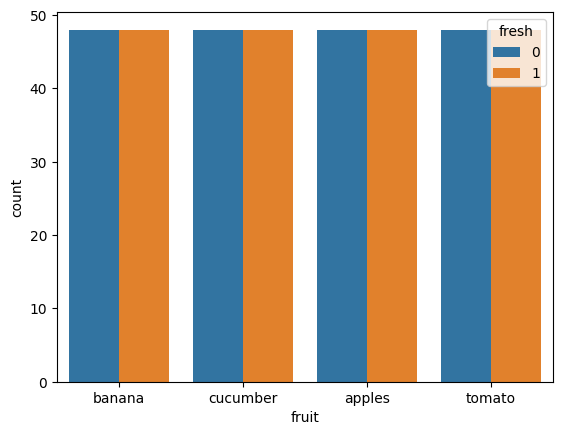

In [ ]:
# Train Dataset Representation:
# Total Training Images: 384
# 96 images per fruit (48 fresh and 48 rotten)
# Labels: 0 for Fresh, 1 for Rotten
import seaborn as sea
sea.countplot(x = 'fruit', data = df_train, hue = 'fresh')

<Axes: xlabel='fruit', ylabel='count'>

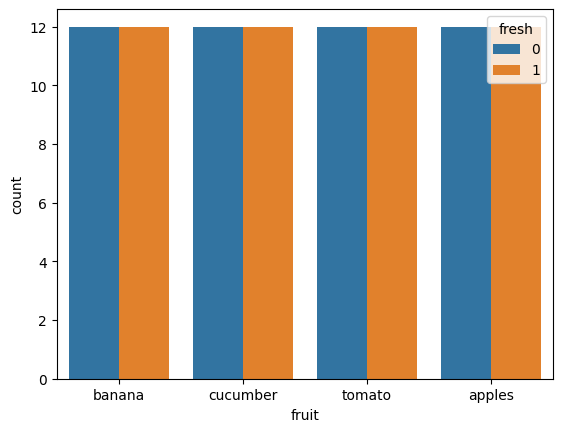

In [ ]:
# Test Dataset Representation:
# Total Testing Images: 96
# 24 images per fruit (12 fresh and 12 rotten)
# Labels: 0 for Fresh, 1 for Rotten
import seaborn as sea
sea.countplot(x = 'fruit', data = df_test, hue = 'fresh')

##Building the dataset
- The images were resized to 224x224.


In [ ]:
from torchvision import transforms

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Dataset class
class FruitDataset(Dataset):
    def __init__(self, df, label_encoder, transform=None):
        self.df = df
        self.label_encoder = label_encoder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filename']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        fruit_label = self.label_encoder.transform([row['fruit']])[0]
        fresh_label = row['fresh']
        return image, fruit_label, fresh_label

# Initialize datasets
le = LabelEncoder()
le.fit(pd.concat([df_train['fruit'], df_test['fruit']]).unique())
train_dataset = FruitDataset(df_train, label_encoder=le, transform=transform)
test_dataset = FruitDataset(df_test, label_encoder=le, transform=transform)

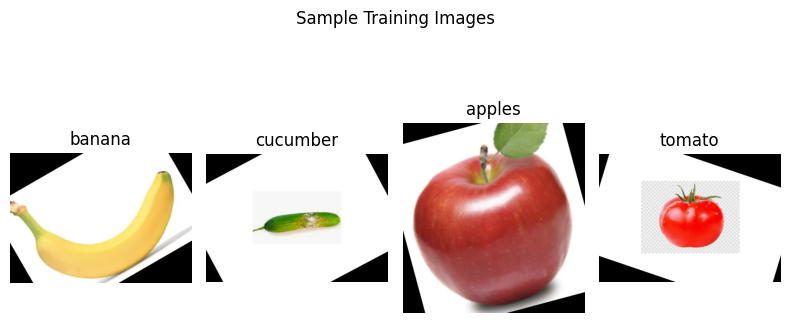

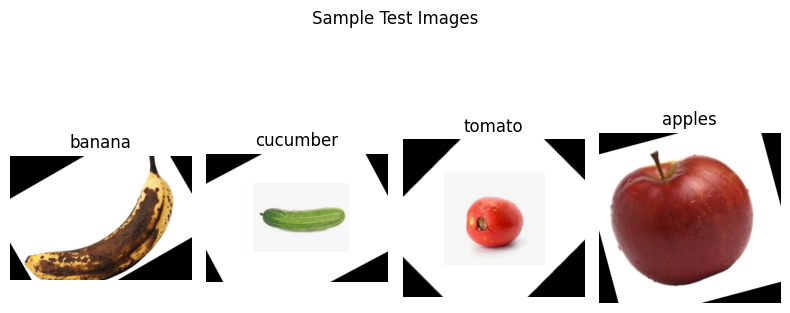

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Displaying sample images from training and testing sets
def display_samples(df, title):
    plt.figure(figsize=(8, 4))
    unique_labels = df['fruit'].unique()

    for i, label in enumerate(unique_labels):
        subset_df = df[df['fruit'] == label]
        sample_path = subset_df.sample(n=1)['filename'].values[0]

        plt.subplot(1, len(unique_labels), i + 1)
        img = Image.open(sample_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{label}')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Assuming df_train and df_test are predefined DataFrames containing the 'fruit' and 'filename' columns
display_samples(df_train, "Sample Training Images")
display_samples(df_test, "Sample Test Images")

## CNN Model Architecture

- Resnet18 pretrained model for this task.

- ResNet-18 is composed of multiple residual blocks, which are designed to address the problem of vanishing gradients in deep neural networks. These blocks introduce skip connections, allowing information to bypass several layers and flow directly to deeper layers. This helps in mitigating the degradation problem and enables the network to learn more effectively, even with very deep architectures.

- The last layer of the restnet18 was replaced with two dense layers and the output was sent to two branches, first branch predicting the name of the fruit while the other branch predicting if the fruit is fresh or not.

- The Last 15 layers of the resnet18 was made trainable and reamining layers were freezed.

- For the loss calculation, a weighted combination of the losses from both the branches were taken. ( α=0.7 ).

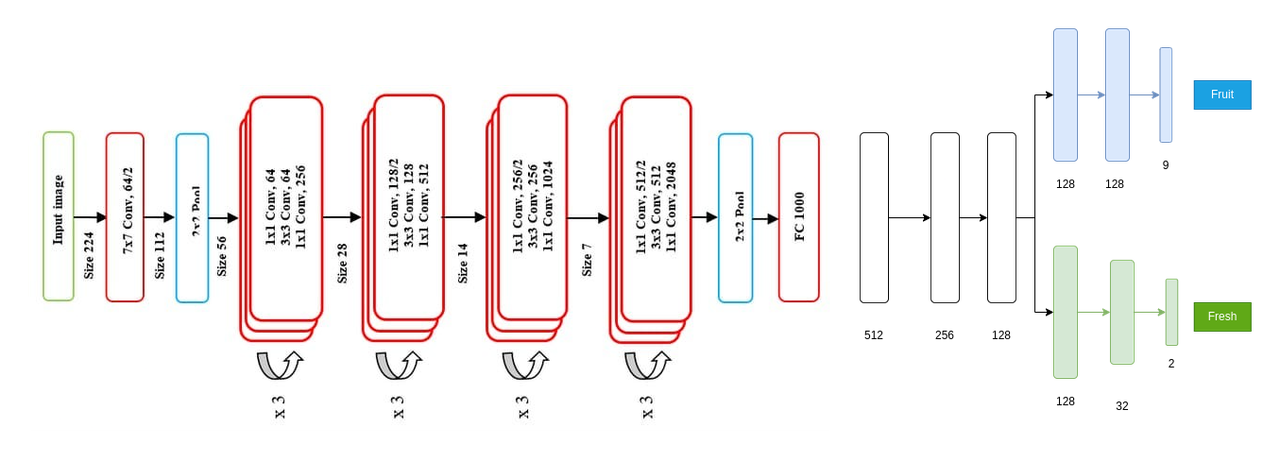

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18  # This imports the specific model directly

class CustomModel(nn.Module):
    def __init__(self, learning_rate=0.001):  # Adjusted default learning rate
        super().__init__()
        self.alpha = 0.7

        # Use the directly imported resnet18
        self.base = resnet18(pretrained=True)
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
        self.base.fc = nn.Sequential()  # Clearing the original fully connected layer

        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128)
        )

        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 4)  # Adjusted to 4 for the number of fruit classes
        )

        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)  # Fresh or not
        )

        self.optimizer1 = torch.optim.Adam([
            {'params': self.base.parameters(), 'lr': learning_rate / 10},
            {'params': self.block1.parameters(), 'lr': learning_rate}
        ])
        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr=learning_rate)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr=learning_rate)

        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=4)
        self.fresh_accuracy = torchmetrics.Accuracy(task='binary')

    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        y1, y2 = self.block2(x), self.block3(x)
        return y1, y2

## Training the model

In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.6MB/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(model, train_loader, optimizer, device, epochs=5):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        epoch_loss = 0.0
        correct_count = 0
        total_count = 0

        for images, fruit_labels, fresh_labels in train_loader:
            images = images.to(device)
            fruit_labels = fruit_labels.to(device)
            fresh_labels = fresh_labels.to(device)

            optimizer.zero_grad()
            fruit_logits, fresh_logits = model(images)
            fruit_loss = model.loss_fxn(fruit_logits, fruit_labels)
            fresh_loss = model.loss_fxn(fresh_logits, fresh_labels)
            loss = model.alpha * fruit_loss + (1 - model.alpha) * fresh_loss  # Use alpha to balance losses
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted_fruits = torch.max(fruit_logits, 1)
            correct_count += (predicted_fruits == fruit_labels).sum().item()
            total_count += fruit_labels.size(0)

        epoch_losses.append(epoch_loss / len(train_loader))
        epoch_accuracy = correct_count / total_count
        epoch_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}: Loss = {epoch_loss / len(train_loader):.4f}, Accuracy = {epoch_accuracy:.4f}')

    return epoch_losses, epoch_accuracies

In [ ]:
epoch_losses, epoch_accuracies = train_model(model, train_loader, optimizer, device, epochs=10)

Epochs:  10%|█         | 1/10 [01:02<09:21, 62.41s/it]

Epoch 1: Loss = 0.6832, Accuracy = 0.8490


Epochs:  20%|██        | 2/10 [01:56<07:39, 57.38s/it]

Epoch 2: Loss = 0.1191, Accuracy = 1.0000


Epochs:  30%|███       | 3/10 [02:49<06:29, 55.60s/it]

Epoch 3: Loss = 0.0445, Accuracy = 1.0000


Epochs:  40%|████      | 4/10 [03:43<05:28, 54.82s/it]

Epoch 4: Loss = 0.0116, Accuracy = 1.0000


Epochs:  50%|█████     | 5/10 [04:37<04:32, 54.56s/it]

Epoch 5: Loss = 0.0022, Accuracy = 1.0000


Epochs:  60%|██████    | 6/10 [05:30<03:36, 54.13s/it]

Epoch 6: Loss = 0.0117, Accuracy = 1.0000


Epochs:  70%|███████   | 7/10 [06:24<02:41, 53.86s/it]

Epoch 7: Loss = 0.0036, Accuracy = 1.0000


Epochs:  80%|████████  | 8/10 [07:21<01:50, 55.03s/it]

Epoch 8: Loss = 0.0026, Accuracy = 0.9974


Epochs:  90%|█████████ | 9/10 [08:14<00:54, 54.49s/it]

Epoch 9: Loss = 0.0007, Accuracy = 1.0000


Epochs: 100%|██████████| 10/10 [09:07<00:00, 54.77s/it]

Epoch 10: Loss = 0.0026, Accuracy = 1.0000


##Plotting CNN Model Results

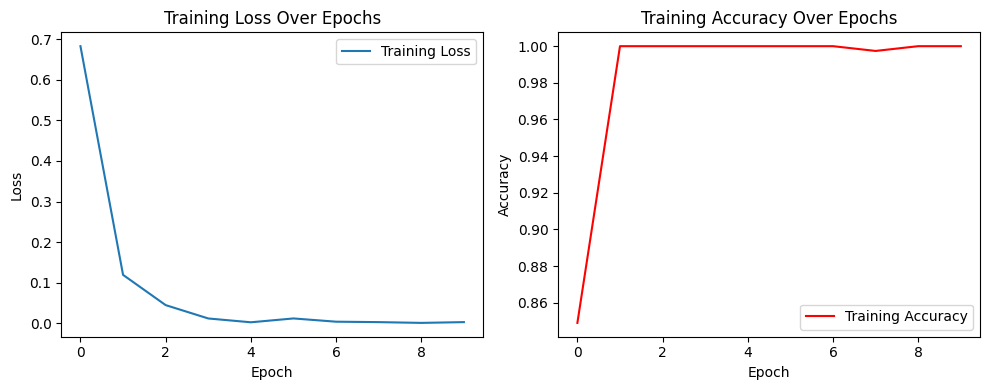

In [ ]:
# Plot the results
def plot_training_results(epoch_losses, epoch_accuracies):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies, label='Training Accuracy', color='r')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_results(epoch_losses, epoch_accuracies)

In [ ]:
global fruit_accuracy, fresh_accuracy
fruit_accuracy = torchmetrics.Accuracy(num_classes=4, average='macro', task='multiclass')
fresh_accuracy = torchmetrics.Accuracy(num_classes=2, average='macro', task='binary')

def evaluate_model(model, test_loader, device):
    model.eval()
    model.to(device)

    global fruit_preds_list, fresh_preds_list, fruits_list, freshs_list
    fruit_preds_list, fresh_preds_list, fruits_list, freshs_list = [], [], [], []

    with torch.no_grad():
        for images, fruits, freshs in test_loader:
            images, fruits, freshs = images.to(device), fruits.to(device), freshs.to(device)
            fruit_logits, fresh_logits = model(images)
            _, fruit_preds = torch.max(fruit_logits, 1)
            _, fresh_preds = torch.max(fresh_logits, 1)
            fruit_preds_list.append(fruit_preds)
            fresh_preds_list.append(fresh_preds)
            fruits_list.append(fruits)
            freshs_list.append(freshs)
            fruit_accuracy.update(fruit_preds, fruits)
            fresh_accuracy.update(fresh_preds, freshs)

evaluate_model(model, test_loader, device)

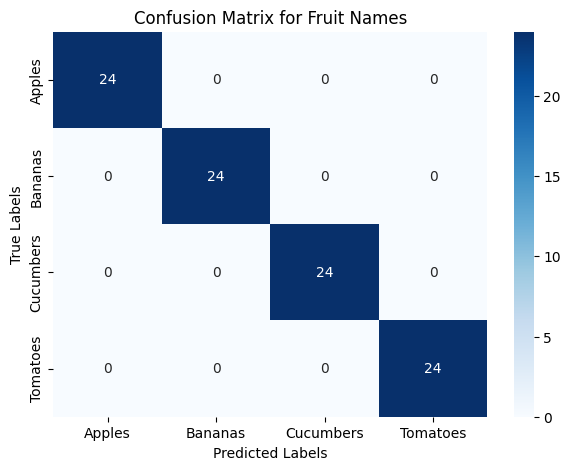

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

fruit_names = ['Apples', 'Bananas', 'Cucumbers', 'Tomatoes']

# Concatenate all predictions and labels
fruit_preds_all = torch.cat(fruit_preds_list)
fruits_all = torch.cat(fruits_list)

# Generate the confusion matrix
cm_fruit = confusion_matrix(fruits_all.cpu(), fruit_preds_all.cpu())

# Plotting the confusion matrix with fruit names
plt.figure(figsize=(7, 5))
sns.heatmap(cm_fruit, annot=True, fmt='d', cmap='Blues', xticklabels=fruit_names, yticklabels=fruit_names)
plt.title('Confusion Matrix for Fruit Names')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

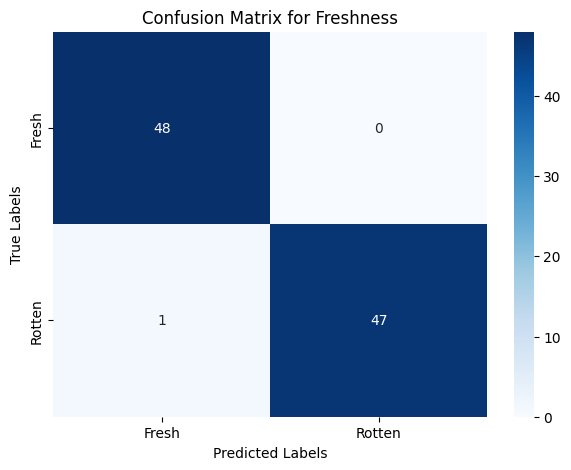

In [ ]:
freshness_labels = ['Fresh', 'Rotten']

# Concatenate all predictions and labels
fresh_preds_all = torch.cat(fresh_preds_list)
freshs_all = torch.cat(freshs_list)

# Generate the confusion matrix
cm_fresh = confusion_matrix(freshs_all.cpu(), fresh_preds_all.cpu())

# Plotting the confusion matrix with custom labels
plt.figure(figsize=(7, 5))
sns.heatmap(cm_fresh, annot=True, fmt='d', cmap='Blues', xticklabels=freshness_labels, yticklabels=freshness_labels)
plt.title('Confusion Matrix for Freshness')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Mapping for fruit labels
fruit_labels = {0: 'Apples', 1: 'Bananas', 2: 'Cucumbers', 3: 'Tomatoes'}
# Mapping for freshness labels
freshness_labels = {0: 'Fresh', 1: 'Rotten'}

# Classification reports with actual labels
print("Classification Report for Fruit Names:")
fruit_report = classification_report(fruits_all.cpu(), fruit_preds_all.cpu(), target_names=[fruit_labels[i] for i in sorted(fruit_labels.keys())])
print(fruit_report)

print("Classification Report for Freshness:")
freshness_report = classification_report(freshs_all.cpu(), fresh_preds_all.cpu(), target_names=[freshness_labels[i] for i in sorted(freshness_labels.keys())])
print(freshness_report)


Classification Report for Fruit Names:
              precision    recall  f1-score   support

      Apples       1.00      1.00      1.00        24
     Bananas       1.00      1.00      1.00        24
   Cucumbers       1.00      1.00      1.00        24
    Tomatoes       1.00      1.00      1.00        24

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Classification Report for Freshness:
              precision    recall  f1-score   support

       Fresh       0.98      1.00      0.99        48
      Rotten       1.00      0.98      0.99        48

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96



In [ ]:
# Compute overall accuracies
fruit_accuracy_final = fruit_accuracy.compute().item()
freshness_accuracy_final = fresh_accuracy.compute().item()
print('Fruit Accuracy:', fruit_accuracy_final)
print('Freshness Accuracy:', freshness_accuracy_final)

Fruit Accuracy: 1.0
Freshness Accuracy: 0.9895833134651184


##ViT Model Architecture

- Vision Transformer utilizes multi-head self-attention and transformer encoders to process image data without requiring image-specific biases.
- By splitting the images into positional embedding patches, ViT can understand both local and global features of the image.
- For this task, applying the Vision Transformer (ViT) model, using the pre-trained model: vit-base-patch16-224
- Adam optimizer is created for the model with a learning rate of 0.001
- Specified latent dimension of size 512



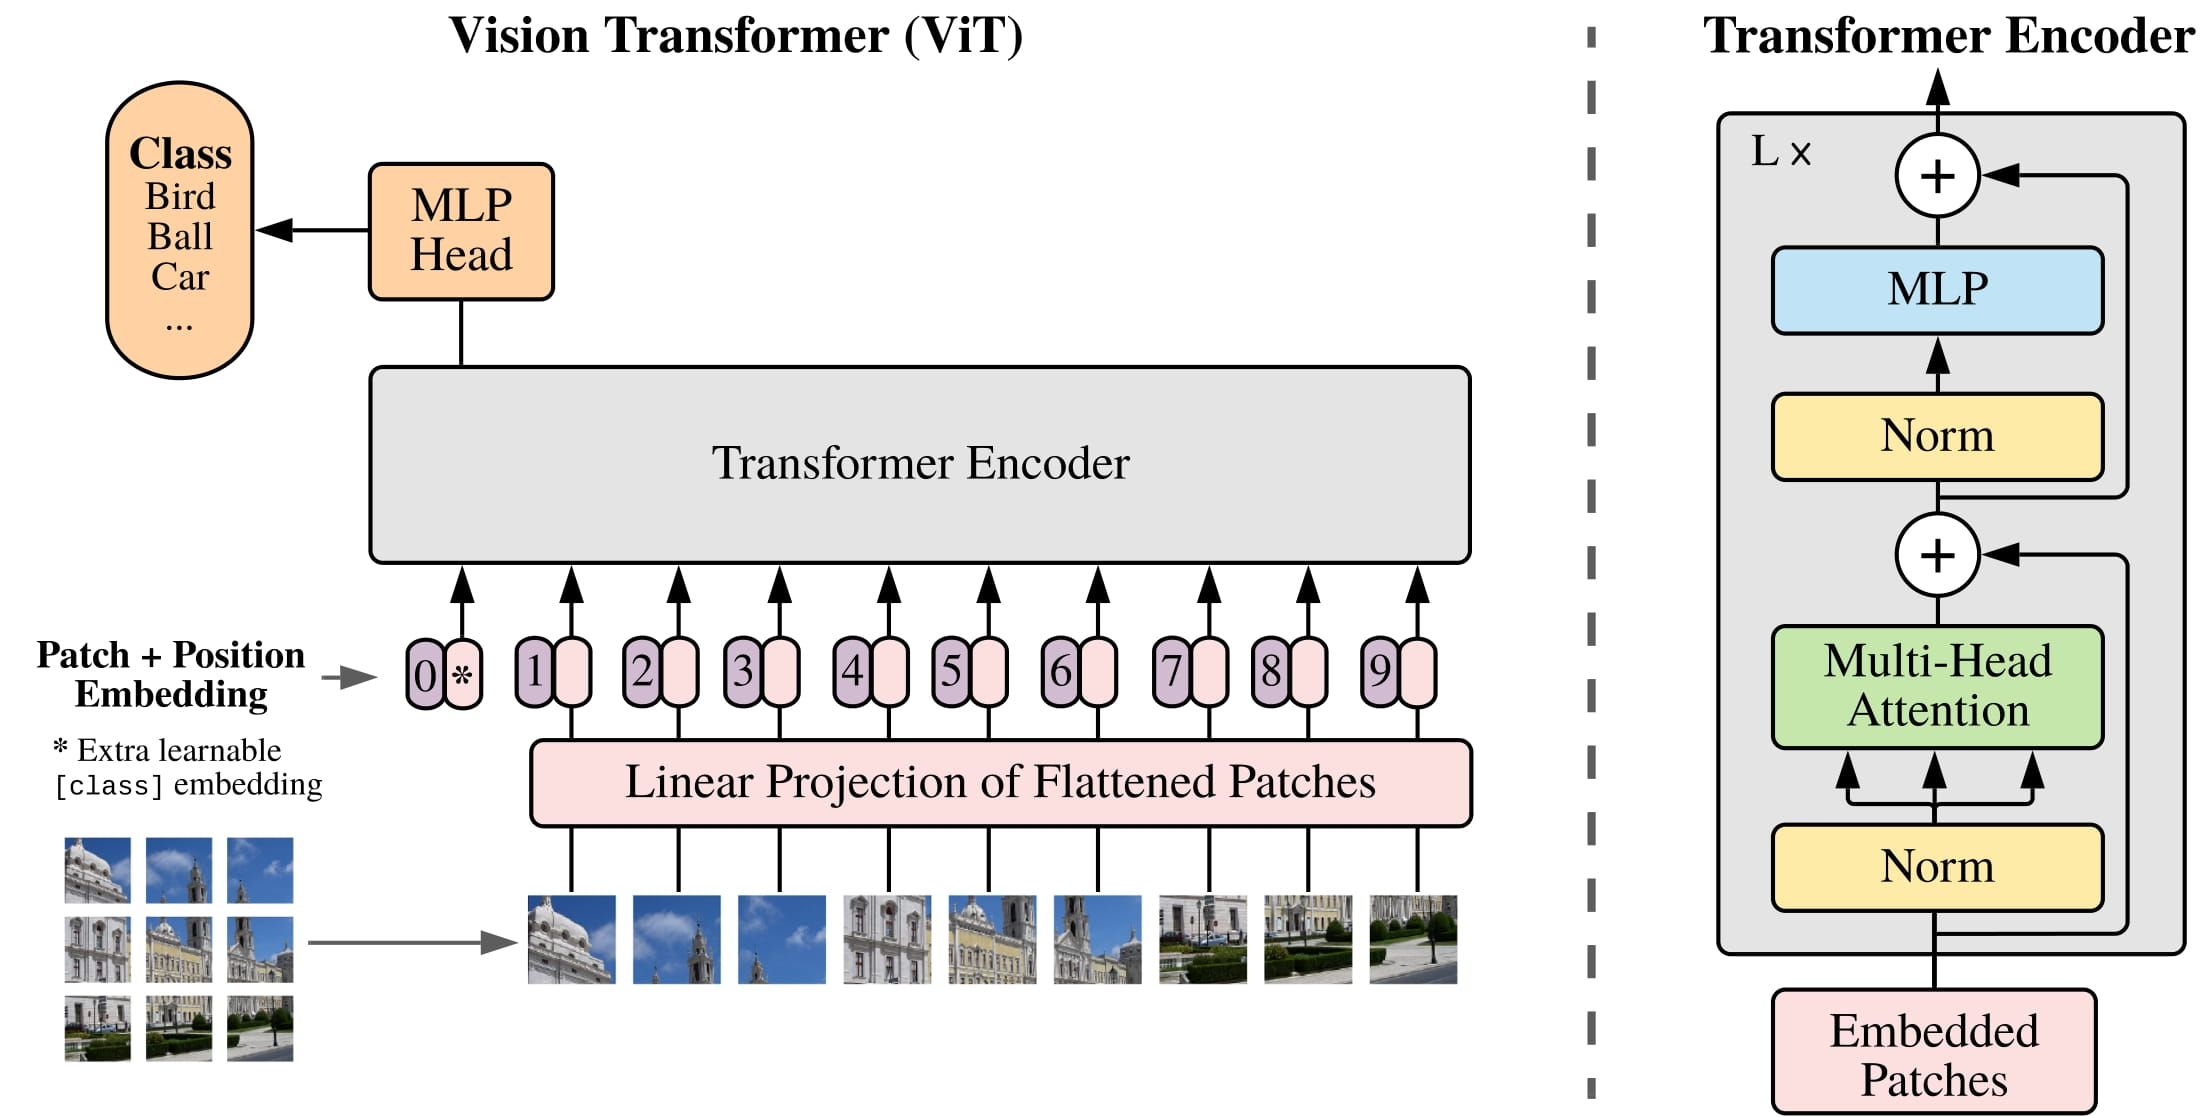

In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms

import os
import numpy as np
from glob import glob

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

## Building ViT Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from transformers import ViTModel
import torchmetrics

class CustomModel2(nn.Module):
    def __init__(self, vit, latent_dim, classes_, learning_rate=0.001):
        super(CustomModel2, self).__init__()

        self.alpha = 0.7
        self.classes_ = classes_

        # Use the directly imported ViTModel
        self.base = vit
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
        self.base.fc = nn.Sequential()  # Clearing the original fully connected layer

        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)

        self.block1 = nn.Sequential(
            nn.Linear(768, latent_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(latent_dim, 128)  # Ensure the dimensions match here
        )

        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 4)  # Adjusted to 4 for the number of fruit classes
        )

        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)  # Fresh or not
        )

        self.optimizer1 = torch.optim.Adam([
            {'params': self.base.parameters(), 'lr': learning_rate / 10},
            {'params': self.fc_1.parameters(), 'lr': learning_rate},
            {'params': self.fc_out.parameters(), 'lr': learning_rate},
        ])
        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr=learning_rate)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr=learning_rate)

        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=4)
        self.fresh_accuracy = torchmetrics.Accuracy(task='binary')

    def forward(self, x):
        vit_outputs = self.base(x)
        pooler_output = vit_outputs.pooler_output

        # First pass through the fc_1 and fc_out layers
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))

        # Now using the original block1, block2, and block3 layers
        x = torch.relu(self.block1(pooler_output))
        x = self.dropout(x)
        y1 = self.block2(x)
        y2 = self.block3(x)
        return y1, y2

## Training the model

In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
latent_dim = 512
classes_ = 4

model = CustomModel2(vit, latent_dim, classes_).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(model, train_loader, optimizer, device, epochs=15):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        epoch_loss = 0.0
        correct_count = 0
        total_count = 0

        for images, fruit_labels, fresh_labels in train_loader:
            images = images.to(device)
            fruit_labels = fruit_labels.to(device)
            fresh_labels = fresh_labels.to(device)

            optimizer.zero_grad()
            fruit_logits, fresh_logits = model(images)
            fruit_loss = model.loss_fxn(fruit_logits, fruit_labels)
            fresh_loss = model.loss_fxn(fresh_logits, fresh_labels)
            loss = model.alpha * fruit_loss + (1 - model.alpha) * fresh_loss  # Use alpha to balance losses
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted_fruits = torch.max(fruit_logits, 1)
            correct_count += (predicted_fruits == fruit_labels).sum().item()
            total_count += fruit_labels.size(0)

        epoch_losses.append(epoch_loss / len(train_loader))
        epoch_accuracy = correct_count / total_count
        epoch_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}: Loss = {epoch_loss / len(train_loader):.4f}, Accuracy = {epoch_accuracy:.4f}')

    return epoch_losses, epoch_accuracies

In [ ]:
epoch_losses, epoch_accuracies = train_model(model, train_loader, optimizer, device, epochs=10)

Epochs:  10%|█         | 1/10 [05:47<52:06, 347.42s/it]

Epoch 1: Loss = 0.8981, Accuracy = 0.8203


Epochs:  20%|██        | 2/10 [11:15<44:49, 336.21s/it]

Epoch 2: Loss = 0.2546, Accuracy = 0.9948


Epochs:  30%|███       | 3/10 [16:41<38:40, 331.44s/it]

Epoch 3: Loss = 0.2157, Accuracy = 0.9948


Epochs:  40%|████      | 4/10 [22:11<33:05, 330.85s/it]

Epoch 4: Loss = 0.1236, Accuracy = 0.9974


Epochs:  50%|█████     | 5/10 [27:36<27:23, 328.68s/it]

Epoch 5: Loss = 0.0471, Accuracy = 0.9974


Epochs:  60%|██████    | 6/10 [33:09<22:00, 330.09s/it]

Epoch 6: Loss = 0.0355, Accuracy = 0.9974


Epochs:  70%|███████   | 7/10 [38:50<16:41, 333.74s/it]

Epoch 7: Loss = 0.0161, Accuracy = 0.9974


Epochs:  80%|████████  | 8/10 [44:34<11:13, 336.90s/it]

Epoch 8: Loss = 0.0028, Accuracy = 1.0000


Epochs:  90%|█████████ | 9/10 [50:17<05:38, 338.92s/it]

Epoch 9: Loss = 0.0028, Accuracy = 1.0000


Epochs: 100%|██████████| 10/10 [56:01<00:00, 336.20s/it]

Epoch 10: Loss = 0.0007, Accuracy = 1.0000


## Plotting ViT model Results

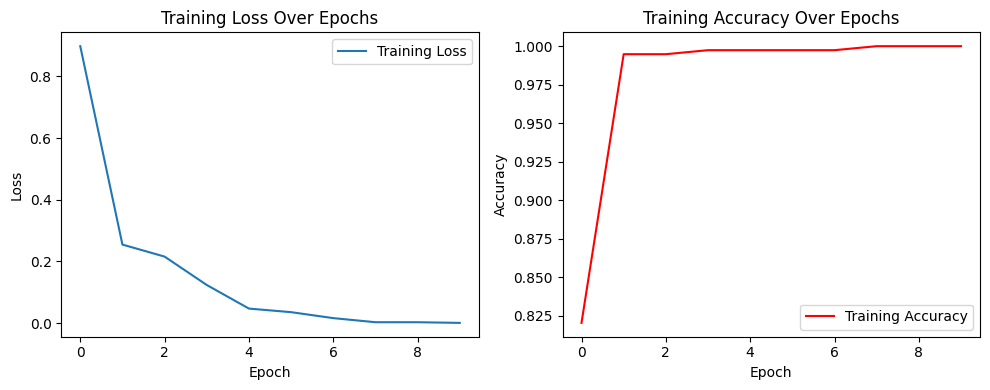

In [ ]:
# Plot the results
def plot_training_results(epoch_losses, epoch_accuracies):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies, label='Training Accuracy', color='r')
    plt.title('Training Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_results(epoch_losses, epoch_accuracies)

In [ ]:
global fruit_accuracy, fresh_accuracy
fruit_accuracy = torchmetrics.Accuracy(num_classes=4, average='macro', task='multiclass')
fresh_accuracy = torchmetrics.Accuracy(num_classes=2, average='macro', task='binary')

def evaluate_model(model, test_loader, device):
    model.eval()
    model.to(device)

    global fruit_preds_list, fresh_preds_list, fruits_list, freshs_list
    fruit_preds_list, fresh_preds_list, fruits_list, freshs_list = [], [], [], []

    with torch.no_grad():
        for images, fruits, freshs in test_loader:
            images, fruits, freshs = images.to(device), fruits.to(device), freshs.to(device)
            fruit_logits, fresh_logits = model(images)
            _, fruit_preds = torch.max(fruit_logits, 1)
            _, fresh_preds = torch.max(fresh_logits, 1)
            fruit_preds_list.append(fruit_preds)
            fresh_preds_list.append(fresh_preds)
            fruits_list.append(fruits)
            freshs_list.append(freshs)
            fruit_accuracy.update(fruit_preds, fruits)
            fresh_accuracy.update(fresh_preds, freshs)

evaluate_model(model, test_loader, device)

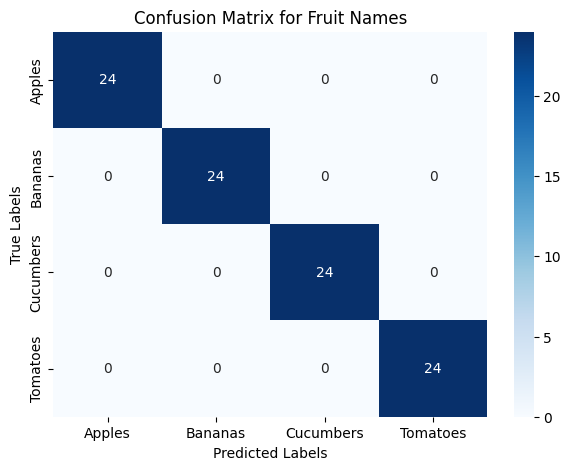

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

fruit_names = ['Apples', 'Bananas', 'Cucumbers', 'Tomatoes']

# Concatenate all predictions and labels
fruit_preds_all = torch.cat(fruit_preds_list)
fruits_all = torch.cat(fruits_list)

# Generate the confusion matrix
cm_fruit = confusion_matrix(fruits_all.cpu(), fruit_preds_all.cpu())

# Plotting the confusion matrix with fruit names
plt.figure(figsize=(7, 5))
sns.heatmap(cm_fruit, annot=True, fmt='d', cmap='Blues', xticklabels=fruit_names, yticklabels=fruit_names)
plt.title('Confusion Matrix for Fruit Names')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

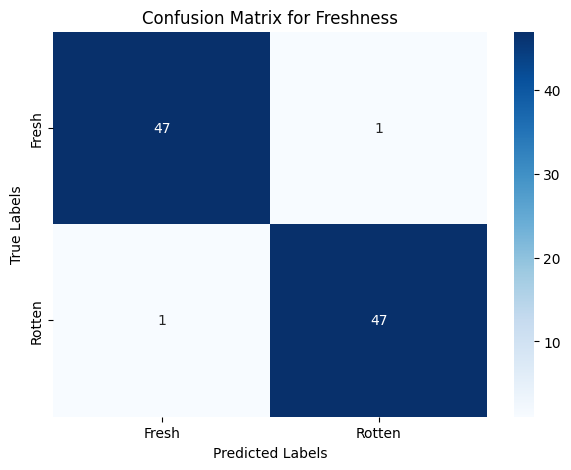

In [ ]:
freshness_labels = ['Fresh', 'Rotten']

# Concatenate all predictions and labels
fresh_preds_all = torch.cat(fresh_preds_list)
freshs_all = torch.cat(freshs_list)

# Generate the confusion matrix
cm_fresh = confusion_matrix(freshs_all.cpu(), fresh_preds_all.cpu())

# Plotting the confusion matrix with custom labels
plt.figure(figsize=(7, 5))
sns.heatmap(cm_fresh, annot=True, fmt='d', cmap='Blues', xticklabels=freshness_labels, yticklabels=freshness_labels)
plt.title('Confusion Matrix for Freshness')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Mapping for fruit labels
fruit_labels = {0: 'Apples', 1: 'Bananas', 2: 'Cucumbers', 3: 'Tomatoes'}
# Mapping for freshness labels
freshness_labels = {0: 'Fresh', 1: 'Rotten'}

# Classification reports with actual labels
print("Classification Report for Fruit Names:")
fruit_report = classification_report(fruits_all.cpu(), fruit_preds_all.cpu(), target_names=[fruit_labels[i] for i in sorted(fruit_labels.keys())])
print(fruit_report)

print("Classification Report for Freshness:")
freshness_report = classification_report(freshs_all.cpu(), fresh_preds_all.cpu(), target_names=[freshness_labels[i] for i in sorted(freshness_labels.keys())])
print(freshness_report)


Classification Report for Fruit Names:
              precision    recall  f1-score   support

      Apples       1.00      1.00      1.00        24
     Bananas       1.00      1.00      1.00        24
   Cucumbers       1.00      1.00      1.00        24
    Tomatoes       1.00      1.00      1.00        24

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Classification Report for Freshness:
              precision    recall  f1-score   support

       Fresh       0.98      0.98      0.98        48
      Rotten       0.98      0.98      0.98        48

    accuracy                           0.98        96
   macro avg       0.98      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96



In [ ]:
# Compute overall accuracies
fruit_accuracy_final = fruit_accuracy.compute().item()
freshness_accuracy_final = fresh_accuracy.compute().item()
print('Fruit Accuracy:', fruit_accuracy_final)
print('Freshness Accuracy:', freshness_accuracy_final)

Fruit Accuracy: 1.0
Freshness Accuracy: 0.9791666865348816
